# QCS with PARALLEL distribution in a star network - EXACT SOLUTIONS

We consider here a parallel QCS scheme in a star network. In a parallel scheme packets are sent in parallel, using all $k$ forwarding stations.

Parameters:
 - `u`: number of users.
 - `k`: number of forwarding stations.
 - `p`: probability that the packets arrive at destination and can be decoded successfully.
 - `n_request`: number of pairs per request.
 - `w_request`: window size of the request.
 - `request_rate`: rate of arrival of new requests per pair of users.
 - `travel_time`: travel time from one user to another through the switch (assume homogeneous network).
 - `fwd_time`: time required to forward a packet.
 - `control_time`: time required to communicate with the network controller.

Our goal is to compute the Mean Sojourn Time (MST): $$\mathrm{MST} =  \mathbb{E}\left[T_\mathrm{service}\right] + \mathbb{E}\left[T_\mathrm{wait}\right]$$

The system can be modelled as an M/G/1 queue, where the service time follows a general distribution given by the $(n,w,p,k)$-window problem. There is an analytical solution in the following cases:

 1. $p=1$:
     - Service time: the number of batches until success in the window problem is $\mathbb{E}\left[B_{n,w,1,k}\right]=\lceil n/k \rceil$, and $\mathrm{Var}\left[B_{n,w,1,k}\right]=0$.
     - Waiting time: the system becomes an M/D/1 queue, whose exact solution is known.

 2. $w\rightarrow\infty$:
     - Service time: The number of batches until success in the window problem follows a known probability distribution (we computed it analytically, it involves many nested sums).
     - Waiting time: the system becomes an M/G/1 queue, whose expected waiting time is given by $$\mathbb{E}\left[T_\mathrm{wait}^\mathrm{M/G/1}\right] = \frac{C_\mathrm{service}^2+1}{2} \mathbb{E}\left[T_\mathrm{wait}^\mathrm{M/M/1}\right],$$ where $C_\mathrm{service}^2 = \mathrm{Var}\left[T_\mathrm{service}\right]/\mathbb{E}\left[T_\mathrm{service}\right]^2$ is the squared coefficient of variation of the service time distribution.


In the following cases, we can only find the MST via approximations (or simulations):


 3. Any $p$, $w$, $k$:
     - Service time: given by the solution of the $(n,w,p,k)$-window problem. Davies2023 provides an analytical method for $k=1$ but it is computationally expensive in general. We have to compute this with a simulation.
     - Waiting time: the system becomes an M/G/1 queue, where the waiting time can be calculated exactly as $$\mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/G/}k}\right] = \frac{C_\mathrm{service}^2+1}{2} \mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/M/}k}\right].$$ Since the window problem has to be solved with a simulation, we may as well use the QCS simulation to compute the MST directly.


In this notebook,
 - ($i$) we use the analytical results to validate our QCS simulator in cases 1 and 2.
 
In `VALIDATION-pQCS-approx.ipynb`,
 - ($ii$) we compare the approximate solutions to our QCS simulation results in 3.

In [5]:
import numpy as np
import math
import importlib as imp
import QCSsimulator as sim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn

In [6]:
# Reference units
clock_cycle = 1 # [us]
speed_light = 0.2 # [km/us] Speed of light in optical fiber

# Protocol
distribution = 'parallel'

---
---
---
# 0. The simulator

We implemented a simulator, `sim.QCS_simulation_time_evolution()` that tracks the evolution of the whole system over time. This simulator provides higher MST than the analytical predictions (i.e., it provides wrong results). We did not manage to find the problem.

Later, we implemented an alternative simulator, `sim.QCS_simulation()` that only updates the data every time a new request arrives. This one seems to agree with analytical calculations!

---
---
---
# 1. $p=1$, $k=1$ (M/D/1) - validation of the simulator

In [7]:
# Topology
u = 5 # Number of users in the star
internode_distance = 10 # [km]
travel_time = int(2*internode_distance/speed_light)
print('travel_time = %d'%travel_time)

# Requests
n_request = 7 # Number of entanglements requested per request
w_request = 11 # [us] Time between delivery of first and last entangled pair
request_rate_vec = np.logspace(-5,-3,5) #np.logspace(-5,-3,20) # [1/us] Request submission rate per pair of users

# Hardware
k = 1 # Number of forwarding devices
fwd_time = 1 # [us] Forwarding time
p = 1 # Probability of successful packet
control_time = 0 # [us]


# Numerical
N_samples = int(1e5)
randomseed = 2

travel_time = 100


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

5 users
n = 7
k = 1
w = 11
p = 1.000


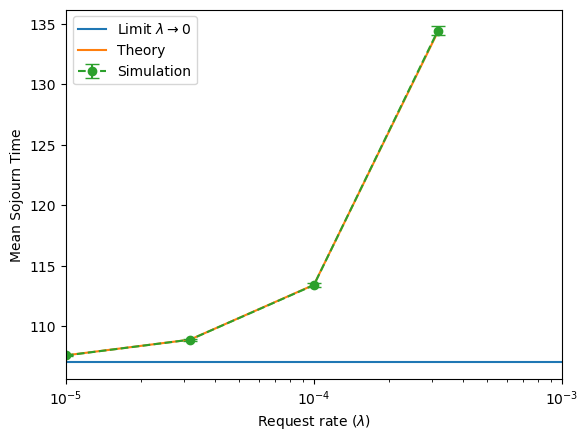

In [8]:
# SIMULATION

imp.reload(sim)

MST_sim_vec = []
MSTerr_sim_vec = []

for request_rate in tqdmn(request_rate_vec, leave=False):
    MST_sim, MSTerr_sim = sim.QCS_simulation(distribution, n_request, w_request, u, k, p,
                           request_rate, travel_time, fwd_time, control_time, N_samples)
    MST_sim_vec += [MST_sim]
    MSTerr_sim_vec += [MSTerr_sim]
    
    

# THEORY

imp.reload(sim)

MST_theory_vec = []

for request_rate in tqdmn(request_rate_vec, leave=False):
    MST_theory = sim.QCS_theory(distribution, n_request, w_request, u, k, p,
                       request_rate, travel_time, fwd_time, control_time)[0]
    MST_theory_vec += [MST_theory]
    
    
    
# PLOT

print('%d users'%u)
print('n = %d'%n_request)
print('k = %d'%k)
print('w = %d'%w_request)
print('p = %.3f'%p)

plt.plot([request_rate_vec[0],request_rate_vec[-1]],
         travel_time+n_request*fwd_time/p*np.ones(2),
         label=r'Limit $\lambda \rightarrow 0$')
plt.plot(request_rate_vec, MST_theory_vec, label='Theory')
plt.errorbar(request_rate_vec, MST_sim_vec, yerr=2*np.array(MSTerr_sim_vec),
             marker='o', linestyle='--', capsize=5, label='Simulation')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(request_rate_vec[0],request_rate_vec[-1])
plt.legend()
plt.xlabel(r'Request rate ($\lambda$)')
plt.ylabel(r'Mean Sojourn Time')
plt.show()

In [9]:
# VALIDATION CASES

# Topology
u_validation = [2,5]
internode_distance = 10
travel_time = int(2*internode_distance/speed_light)
print('travel_time = %d'%travel_time)

# Requests
n_request_validation = [1,7,10]
w_request_validation = [10, 11, 20]
request_rate_validation = np.logspace(-5,-3,5)

# Hardware
k = 1 # Number of forwarding devices
fwd_time = 1 # [us] Forwarding time
p = 1 # Probability of successful packet
control_time = 0 # [us]

# Numerical
N_samples = int(1e5)
randomseed = 2

travel_time = 100


In [10]:
# SIMULATION

imp.reload(sim)


for u in tqdmn(u_validation, leave=False):
    for n_request in tqdmn(n_request_validation, leave=False):
        for w_request in tqdmn(w_request_validation, leave=False):
            for request_rate in tqdmn(request_rate_validation, leave=False):
                MST_sim, MSTerr_sim = sim.QCS_simulation(distribution, n_request, w_request, u, k, p,
                                       request_rate, travel_time, fwd_time, control_time, N_samples)
                MST_theory = sim.QCS_theory(distribution, n_request, w_request, u, k, p,
                                   request_rate, travel_time, fwd_time, control_time)[0]
                if MST_theory > MST_sim+2*MSTerr_sim or MST_theory < MST_sim-2*MSTerr_sim:
                    print('Disagreement for u=%d, n=%d, w=%d, lambda0=%s:'%(u,n_request,w_request,request_rate))
                    print('--- Theory = %.3f'%(MST_theory))
                    print('--- Simul. = %.3f (%.3f)'%(MST_sim, 2*MSTerr_sim))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

---
---
---
# 2. $w\rightarrow\infty$, $k=1$ (M/G/1) - validation of the simulator

In [11]:
# Topology
u = 5 # Number of users in the star
internode_distance = 10 # [km]
travel_time = int(2*internode_distance/speed_light)
print('travel_time = %d'%travel_time)

# Requests
n_request = 7 # Number of entanglements requested per request
w_request = np.inf # [us] Time between delivery of first and last entangled pair
request_rate_vec = np.logspace(-5,-3,10) # [1/us] Request submission rate per pair of users

# Hardware
k = 1 # Number of forwarding devices
fwd_time = 1 # [us] Forwarding time
p = 0.5 # Probability of successful packet
control_time = 0 # [us]


# Numerical
N_samples = int(1e5)
randomseed = 2

travel_time = 100


In [13]:
imp.reload(sim)

MST_theory_vec = []
MST_sim_vec = []
MSTerr_sim_vec = []

for request_rate in tqdmn(request_rate_vec, leave=False):
    MST_sim, MSTerr_sim = sim.QCS_simulation(distribution, n_request, w_request, u, k, p,
                           request_rate, travel_time, fwd_time, control_time, N_samples)

    MST_theory = sim.QCS_theory(distribution, n_request, w_request, u, k, p,
                       request_rate, travel_time, fwd_time, control_time)[0]

    MST_theory_vec += [MST_theory]
    MST_sim_vec += [MST_sim]
    MSTerr_sim_vec += [MSTerr_sim]

  0%|          | 0/10 [00:00<?, ?it/s]

5 users
n = 7
k = 1
w = inf
p = 0.500


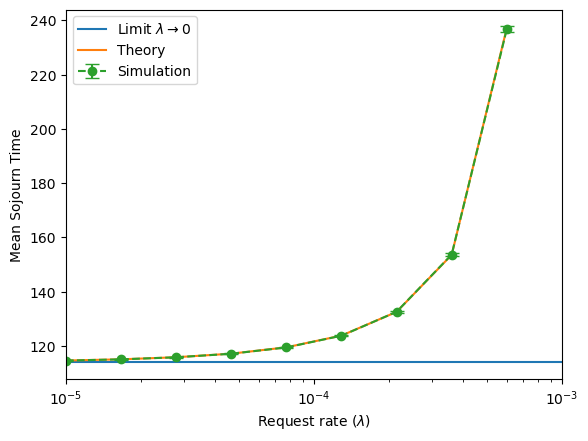

In [14]:
print('%d users'%u)
print('n = %d'%n_request)
print('k = %d'%k)
print('w = %s'%w_request)
print('p = %.3f'%p)

plt.plot([request_rate_vec[0],request_rate_vec[-1]],
         travel_time+n_request*fwd_time/p*np.ones(2),
         label=r'Limit $\lambda \rightarrow 0$')
plt.plot(request_rate_vec, MST_theory_vec, label='Theory')
plt.errorbar(request_rate_vec, MST_sim_vec, yerr=2*np.array(MSTerr_sim_vec),
             marker='o', linestyle='--', label='Simulation', capsize=5)
plt.xscale('log')
#plt.yscale('log')
plt.xlim(request_rate_vec[0],request_rate_vec[-1])
plt.legend()
plt.xlabel(r'Request rate ($\lambda$)')
plt.ylabel(r'Mean Sojourn Time')
plt.show()